# Hot region construction

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius, _csq, _km, _M_s, _2pi
from xpsi.cellmesh.mesh_tools import eval_cedeCentreCoords

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                 Version: 0.1                |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/



Let's explore higher-complexity surface hot regions models. First we need to do some setup of the ambient spacetime and the surface embedded in it that the photosphere exists on.

In [2]:
class CustomSpacetime(xpsi.Spacetime):
    """ A custom spacetime object.
    
    The coordinate rotation frequency of the star is fixed.
    
    """

    def __init__(self, num_params, bounds, S):
        """
        :param int num_params: The number of spacetime parameters.
        :param float S: The coordinate rotation frequency (Hz).
        
        """
        super(CustomSpacetime, self).__init__(num_params, bounds)

        try:
            self._S = float(S)
        except TypeError:
            raise TypeError('Coordinate spin frequency must be a ``float``.')
        else:
            self._Omega = 2.0 * math.pi * S

In [3]:
bounds = [(0.1, 1.0), # (Earth) distance
          (1.0, 3.0), # gravitational mass
          (3.0 * gravradius(1.0), 16.0), # coordinate equatorial radius
          (0.001, math.pi/2.0)] # (Earth) inclination to rotation axis

spacetime = CustomSpacetime(num_params = 4, bounds = bounds, S = 300.0)

Now we instantiate hot region objects.

In [4]:
bounds = [(0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (5.1, 6.8)]

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(num_params=3, bounds=bounds,
                            symmetry=True,
                            hole=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False)

bounds = [(0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (0.001, math.pi - 0.001),
          (0.0, 2.0),
          (0.0, 2.0*math.pi),
          (5.1, 6.8)]

# overlap of a non-radiating superseding member region
# and a radiating ceding member region
secondary = xpsi.HotRegion(num_params=6, bounds=bounds,
                              symmetry=True,
                              hole=True,  # this "hole" is a non-radiating superseding member
                              cede=False, # this means that the ceding member is superseded by the "hole"
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True)

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Note that the ``{min,max}_sqrt_num_cells`` keyword arguments set the maximum number of elements that the vicinity of a hot region will be discretised into in both colatitude and azimuth.

Let's also explicitly fill the photosphere *elsewhere* with a simple radiation field. We will return to this later when we integrate over the surface radiation field to calculate signals.

In [5]:
elsewhere = xpsi.Elsewhere(1, bounds=[(5.4,6.4)])

In [6]:
photosphere = xpsi.Photosphere(tag = 'all', hot = hot, elsewhere = elsewhere)

In [7]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

We will now define helper functions for plotting mesh representations, together with some plot settings. 

In [8]:
def plot_meshes(lines=(True,True),
                primary_ticks = (1,5),
                secondary_ticks = (1,5)):
    """ Plot representations of the cached meshes.
    
    Note that the lowest colatitude row of elements is plotted as the
    lowest row, so colatitude increases along the y-axis and azimuth
    increaes along the x-axis. This could be considered as spatially
    inverted if we were looking at the star whilst being oriented
    such that "up" is in the spin direction.
    
    """

    fig = plt.figure(figsize = (9, 19))

    gs = gridspec.GridSpec(2, 2, width_ratios=[50,1], wspace=0.1, hspace=0.1)
    ax = plt.subplot(gs[0,0])
    veneer(primary_ticks, primary_ticks, ax)

    # primary (lower colatitude) hot region
    z = hot.objects[0]._HotRegion__cellArea[0]/np.max(hot.objects[0]._HotRegion__cellArea[0])
    patches = plt.pcolormesh(z,
                             vmin = np.min(z),
                             vmax = np.max(z),
                             cmap = cm.magma,
                             linewidth = 1.0 if lines[0] else 0.0,
                             rasterized = True,
                             edgecolor='black')

    ax = plt.subplot(gs[1,0])
    veneer(secondary_ticks, secondary_ticks, ax)

    # secondary (higher colatitude) hot region
    z = hot.objects[1]._HotRegion__cellArea[0]/np.max(hot.objects[1]._HotRegion__cellArea[0])
    _ = plt.pcolormesh(z,
                       vmin = np.min(z),
                       vmax = np.max(z),
                       cmap = cm.magma,
                       linewidth = 1.0 if lines[1] else 0.0,
                       rasterized = True,
                       edgecolor='black')

    ax_cb = plt.subplot(gs[:,1])
    cb = plt.colorbar(patches,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length)
    axes.tick_params(which='minor', colors='black', length=int(length/2))
    axes.xaxis.set_tick_params(which='both', width=lw)
    axes.yaxis.set_tick_params(which='both', width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

Let's form a vector of parameter values in the *conventional* order expected by the ``Star`` instance and the other objects it encapsulates references to.

In [9]:
class Vector(object):
    """ The ordered parameter vector.
    
    This object should be useful if you are unfamiliar with
    the convention for parameter ordering. This particular
    class is configured only for ``Star`` object we defined above.
    
    """
    
    def __init__(self, p=None):
        
        if p is not None:
            (self.D,
                self.M,
                self.R,
                self.i,
                self.spot_colat,
                self.spot_radius,
                self.spot_temp,
                self.cede_colat,
                self.cede_radius,
                self.hole_colat,
                self.hole_radius,
                self.hole_azi,
                self.cede_temp,
                self.elsewhere_temp) = p
        else:
            # (Earth) distance
            self.D = 0.329
            # gravitational mass
            self.M = 1.4
            # coordinate equatorial radius
            self.R = 13.18
            # (Earth) inclination to rotation axis
            self.i = 1.0
            # primary hot region (spot) centre colatitude
            self.spot_colat = 2.19
            # primary spot angular radius
            self.spot_radius = 0.0792
            # primary spot effective temperature
            self.spot_temp = 6.11
            # secondary hot region ceding member (CM) centre colatitude
            self.cede_colat = math.pi/2.0
            # secondary hot region CM angular radius
            self.cede_radius = 0.32                
            # secondary hot region hole centre colatitude
            self.hole_colat = math.pi/2.0
            # secondary hot region hole angular radius
            self.hole_radius = 0.25
            # secondary hot region hole centre relative azimuth 
            self.hole_azi = 0.0
            # secondary hot region effective temperature
            self.cede_temp = 6.12
            # elsewhere effective temperature
            self.elsewhere_temp = 5.6 
                
    def __call__(self):
        """
        :returns: The ordered parameter vector for the star.
        :rtype: *list*
        
        """
        
        return [self.D,
                self.M,
                self.R,
                self.i,
                self.spot_colat,
                self.spot_radius,
                self.spot_temp,
                self.cede_colat,
                self.cede_radius,
                self.hole_colat,
                self.hole_radius,
                self.hole_azi,
                self.cede_temp,
                self.elsewhere_temp]
    
    @property
    def D(self):
        return self._D
        
    @D.setter
    def D(self, D):
        self._D = D
        
    @property
    def M(self):
        return self._M
        
    @M.setter
    def M(self, M):
        self._M = M
        
    @property
    def R(self):
        return self._R
        
    @R.setter
    def R(self, R):
        self._R = R
        
    @property
    def i(self):
        return self._i
        
    @i.setter
    def i(self, i):
        self._i = i
        
    @property
    def spot_colat(self):
        return self._spot_colat
        
    @spot_colat.setter
    def spot_colat(self, spot_colat):
        self._spot_colat = spot_colat
        
    @property
    def spot_radius(self):
        return self._spot_radius
        
    @spot_radius.setter
    def spot_radius(self, spot_radius):
        self._spot_radius = spot_radius
        
    @property
    def spot_temp(self):
        return self._spot_temp
        
    @spot_temp.setter
    def spot_temp(self, spot_temp):
        self._spot_temp = spot_temp
        
    @property
    def cede_colat(self):
        return self._cede_colat
        
    @cede_colat.setter
    def cede_colat(self, cede_colat):
        self._cede_colat = cede_colat
        
    @property
    def cede_radius(self):
        return self._cede_radius
        
    @cede_radius.setter
    def cede_radius(self, cede_radius):
        self._cede_radius = cede_radius
        
    @property
    def hole_colat(self):
        return self._hole_colat
        
    @hole_colat.setter
    def hole_colat(self, hole_colat):
        self._hole_colat = hole_colat
    
    @property
    def hole_radius(self):
        return self._hole_radius
        
    @hole_radius.setter
    def hole_radius(self, hole_radius):
        self._hole_radius = hole_radius
        
    @property
    def hole_azi(self):
        return self._hole_azi
        
    @hole_azi.setter
    def hole_azi(self, hole_azi):
        self._hole_azi = hole_azi
        
    @property
    def cede_temp(self):
        return self._cede_temp
        
    @cede_temp.setter
    def cede_temp(self, cede_temp):
        self._cede_temp = cede_temp
        
    @property
    def elsewhere_temp(self):
        return self._elsewhere_temp
        
    @elsewhere_temp.setter
    def elsewhere_temp(self, elsewhere_temp):
        self._elsewhere_temp = elsewhere_temp

In [10]:
v = Vector()

We now prepare the star for pulse integration. In statistical contexts the likelihood function places this call automatically. The preparation involves embedding hot region objects into the photosphere (that also radiates elsewhere), by constructing element (or cell) meshes and precomputing ray mapping information for image integration. We place a call to our helper function to plot the meshes constructed: the mesh for the primary hot region is rendered in the topmost panel, with colour representing the proper area covered by the hot region within a given element. This area weights the pulse generated by an infinitesimal radiating element located at the proper-area-weighted centre of the element. The mesh associated with the secondary hot region is rendered in the bottommost panel.

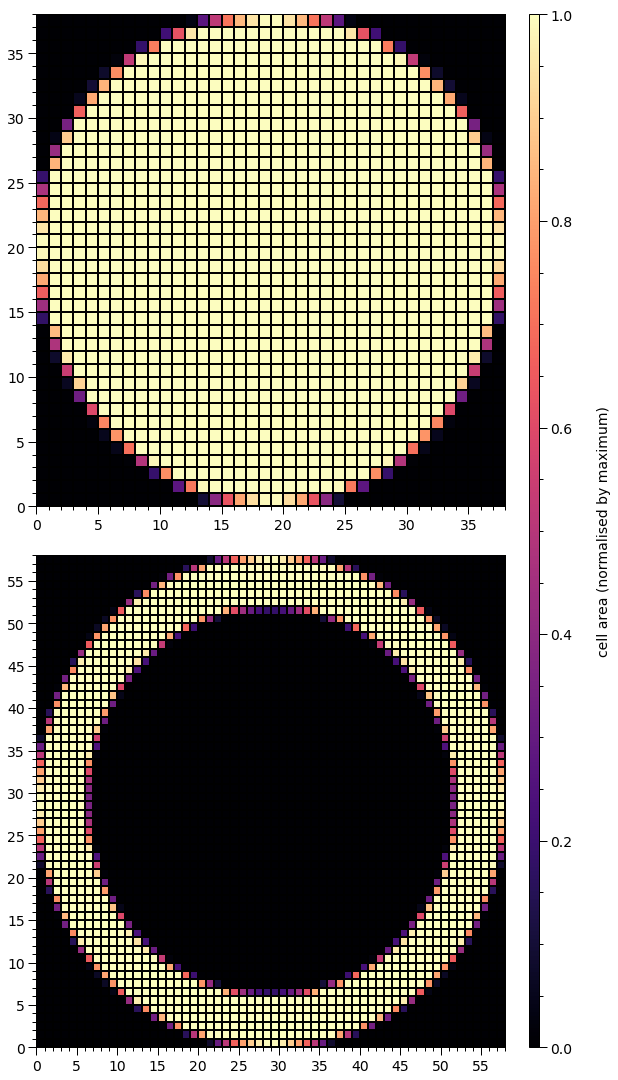

In [11]:
star.update(v())

plot_meshes()

We have a ring for secondary hot region. The hole would be automatically filled with the radiation field *elsewhere*, which might, e.g., be much cooler.

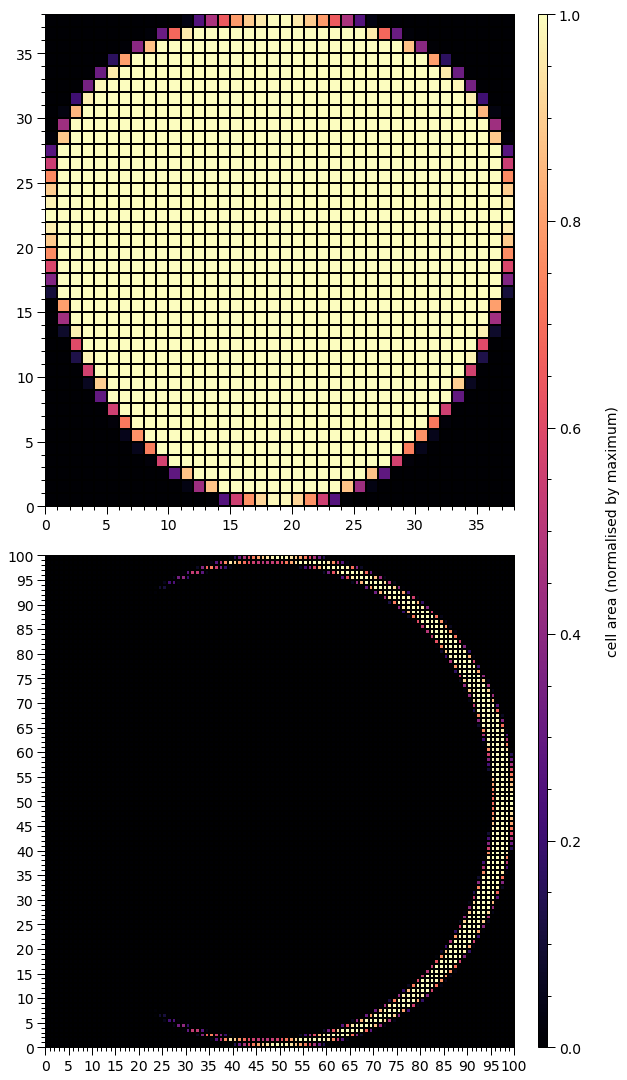

In [12]:
v.spot_radius = 0.25   # increase the primary spot angular radius
v.hole_radius = 0.31   # increase the angular radius of the hole
v.hole_azi = -0.02     # introduce a finite azimuthal hole offset

star.update(v())

plot_meshes()

We have a crescent that is symmetric about the equator. Note that, confusingly, the *hole* is not actually a hole. The current object naming convention in the source code means that this is referred to as a hole, although it is not topologically true. A better way to think about this configuration is to consider a superseding member that supersedes a ceding member with the *elsewhere* radiation field.

Given that the superseding member is not a topological hole, the resulting crescent has *terminal points* or *horns*. As one approaches the horns around the crescent, the cell areas approach zero, and the two cells containing the two terminal points, and the adjacent cells cannot be resolved in colour from the cells that have zero coverage of the hot region. We can pick out these cells at the horns by setting a uniform colour for cells of finite area:

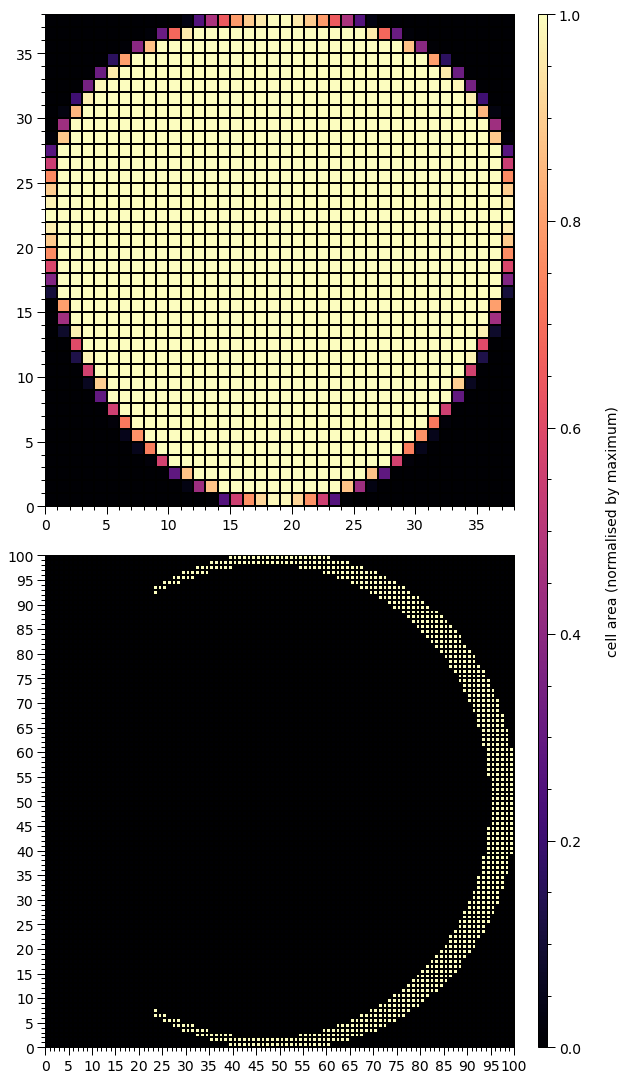

In [13]:
h = hot.objects[1]

# in the source code, there is always a radiating "super" region
# even if the "hole" is equivalent to a non-radiating superseding member
# and the "super" region is then really a ceding member
h._super_cellArea[h._super_cellArea > 0.0] = 1.0

plot_meshes()

We can now see all cells with finite hot region coverage, and the symmetry is perhaps clearer.

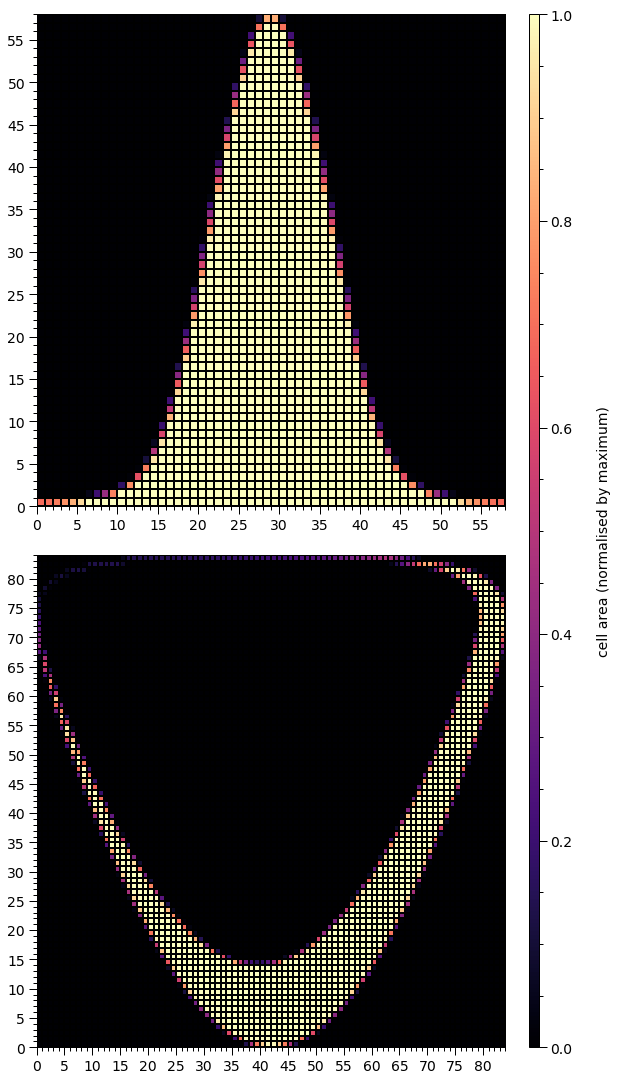

In [14]:
v.spot_colat = 2.9     # increase the colatitude of the primary spot centre
v.spot_radius = 0.3    # increase the angular radius of the primary spot
v.cede_colat = 2.72   # this is not equal
v.hole_colat = 2.75    # to this anymore
v.hole_radius = 0.284  #
v.hole_azi = -0.0483   # increase the magnitude of hole azimuthal offset

star.update(v())

plot_meshes()

Note that a fundamental property of the topmost mesh has now changed: the boundary in azimuth is periodic because the spot encompasses a pole (the southern rotational pole), whilst the lower boundary in colatitude is actually a coordinate singularity. The boundary in azimuth for the bottommost mesh is *not* periodic. The *hole* is close enough to being a topological hole that we cannot distinguish whether or not it is from the mesh, and we would need to calulate the sum of the angular radius of the hole with the angular separation between the centres.

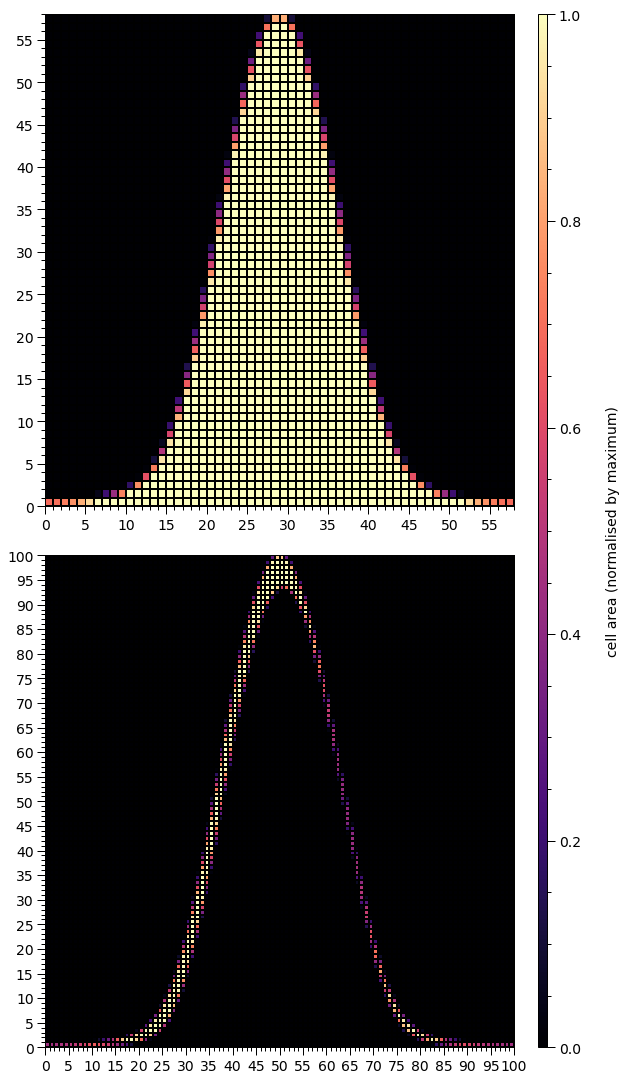

In [15]:
v.spot_colat = math.pi - 2.9   # reflect primary spot w.r.t equator
v.cede_colat = 2.87           # increase CM centre colatitude
v.hole_colat = v.cede_colat   # increase hole centre colatitude
v.hole_radius = 0.3            # increase the hole angular radius
v.hole_azi *= -1.0             # positive hole offset

star.update(v())

plot_meshes()

Note that although the primary spot was reflected about the equator, and now encompasses the northern rotation pole, the mesh does not look as though it has been reflected. Under the hood, the mesh for the primary spot encompassing the southern rotational pole is constructed as reflection about the equator, and then the mesh of colatitudes, which is not plotted but has the same shape as the mesh of proper areas (plotted), is transformed via $\theta\mapsto\pi-\theta$, leaving other reflection-symmetric properties intact. 

The mesh for the secondary hot region has now joined that of the primary in having a periodic boundary in azimuth. Note that the hole also encompasses the southern rotational pole.

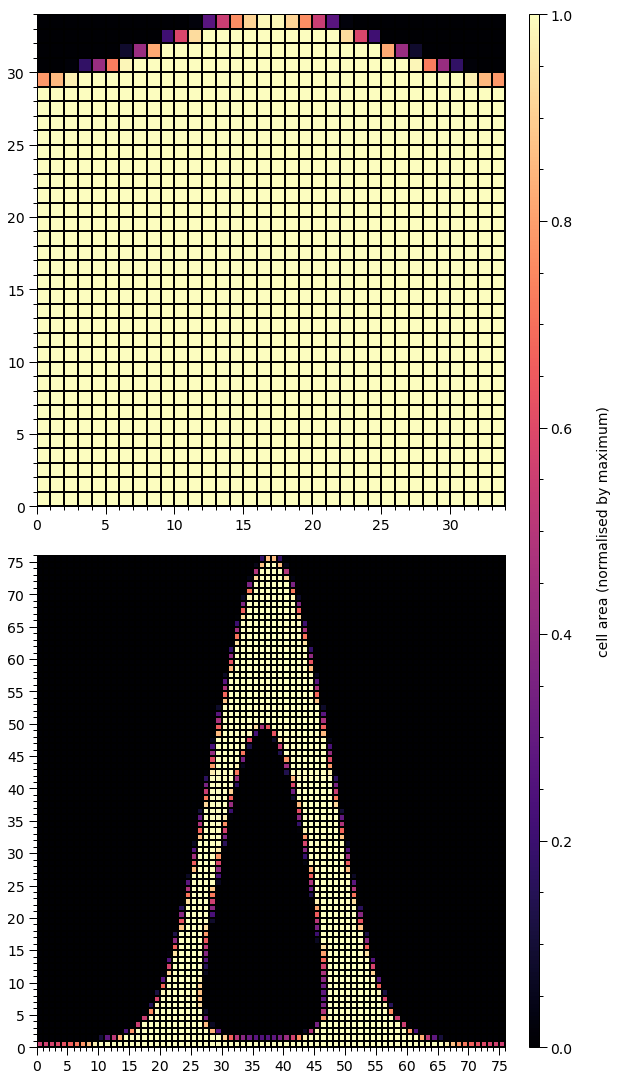

In [16]:
p = [0.328978844399083370E+00,
        0.140337033600940120E+01,
        0.133784624585842025E+02,
        0.100434973113637094E+01,
        math.pi - 0.01, # move primary spot centre almost to south pole 
        0.3,
        0.610655622382022134E+01,
        0.27, # move secondary hot region to encompass north pole
        0.32,
        0.275,
        0.2, # decrease the angular radius of the hole
        -0.1, # increase magnitude of hole azimuthal offset
        0.611730491798804454E+01,
        5.6]

star.update(p)

plot_meshes()

The primary spot centre is now almost coincident with a pole, with the angular separation between pole and centre much smaller than the angular radius of the spot. Meanwhile, the hole in the secondary hot region is a topological hole, but does not encompass a pole, whilst the outer boundary of the resulting ring *does*.

Let's increase the resolution for one of the examples above to some ridiculous level that is not even accurately rendered:

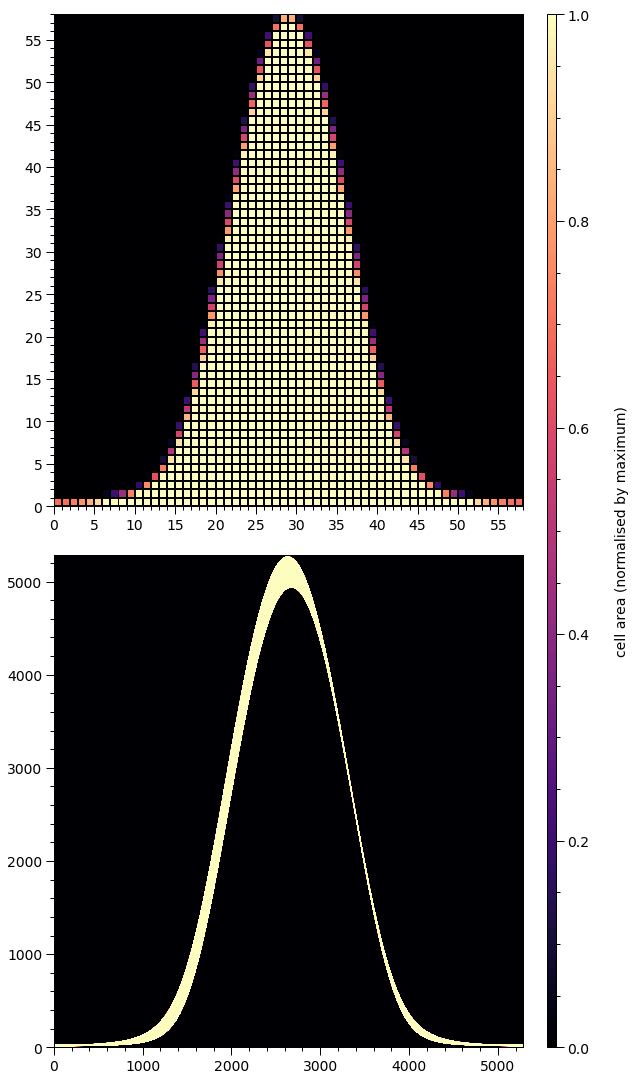

In [18]:
p = [0.328978844399083370E+00,
        0.140337033600940120E+01,
        0.133784624585842025E+02,
        0.100434973113637094E+01,
        math.pi - 2.9, # reflect primary spot w.r.t equator
        0.3,
        0.610655622382022134E+01,
        2.87, # increase CM centre colatitude
        0.32,
        2.87, # increase hole centre colatitude
        0.3, # increase the hole angular radius
        0.483260905056053860E-01, # positive hole offset
        0.611730491798804454E+01,
        5.6]

h = hot.objects[1]

h.set_num_cells(sqrt_num_cells=1000, max_sqrt_num_cells=10000)

star.update(p)

plot_meshes(lines=(True, False), secondary_ticks=None)

There are other parametrisations that are useful to consider that might be more natural for prior implementation. The helper function below is an example.

In [21]:
def transform(p, v):
    """ Transform a parameter vector from a useful space to another.
    
    Specifically, the input vector ``p`` is constituted by:
    
        * the fractional angular offset between the centres of the "hole" and ceding member
        * the azimuthal offset of the ceding member about the centre of the "hole"
        
    The "hole" is a non-radiating superseding region that *might* be a topological hole
    in the ceding member region.
        
    """
    
    if v.hole_radius <= v.cede_radius:
        t1 = p[0] * (v.cede_radius + v.cede_radius)
    else:
        t1 = v.hole_radius - v.cede_radius + 2.0*p[0]*v.cede_radius

    v.cede_colat, v.hole_azi = eval_cedeCentreCoords(v.hole_colat, t1, p[1])

    v.hole_azi *= -1.0

    return p

Let's try to recreate (approximately, although it can of course be done exactly by inverting the transformation) the crescent above that is symmetric with respect to the equator.

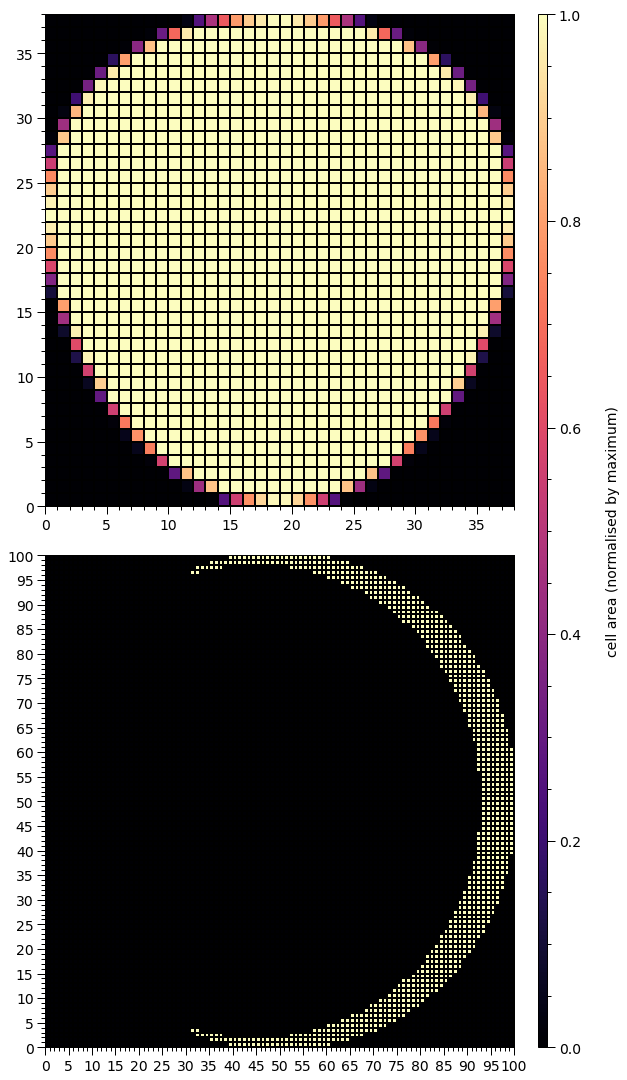

In [22]:
v = Vector()           # reinitialise
v.spot_radius = 0.25   # increase the primary spot angular radius
v.hole_radius = 0.31   # increase the angular radius of the hole
v.hole_colat = math.pi/2.0

p = [0.05, math.pi/2.0]

transform(p, v)
       
star.update(v())

# make sure all elements with finite coverage are discernable
h = hot.objects[1]

# in the source code, there is always a radiating "super" region
# even if the "hole" is equivalent to a non-radiating superseding member
# and the "super" region is then really a ceding member
h._super_cellArea[h._super_cellArea > 0.0] = 1.0

plot_meshes()

## Pulse integration

Let's compute some pulses. First we need a helper function.

In [23]:
from xpsi.tools import phase_interpolator

def plot_2D_pulse(z, x, shift, y, ylabel, num_rotations=5.0, res=5000, cm=cm.viridis):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator.interpolate_pulse(new_phases,
                                                        x,
                                                        z[0], shift[0])
    interpolated += phase_interpolator.interpolate_pulse(new_phases,
                                                         x,
                                                         z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 5.0])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

Let's compute the incident specific flux signal, in units of photons/cm$^{2}$/s/keV output as by the source code, and then normalise it to the maximum specific flux:

In [50]:
energies = np.logspace(-2.0, np.log10(3.0), 1000, base=10.0)

In [51]:
v.D = 0.2
v.M = 1.4
v.R = 12.5
v.i = 1.0
v.spot_colat = 1.0
v.spot_radius = 0.075
v.spot_temp = 6.2
v.cede_colat = math.pi - 1.0
v.cede_radius = 0.2
v.hole_colat = math.pi - 1.0
v.hole_radius = 0.02
v.hole_azi = 0.0
v.cede_temp = 6.0
v.elsewhere_temp = 0.0 # turn this off for now

star.update(v())

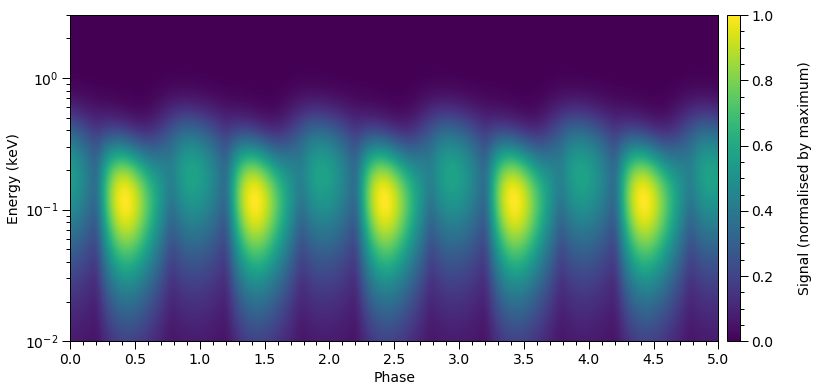

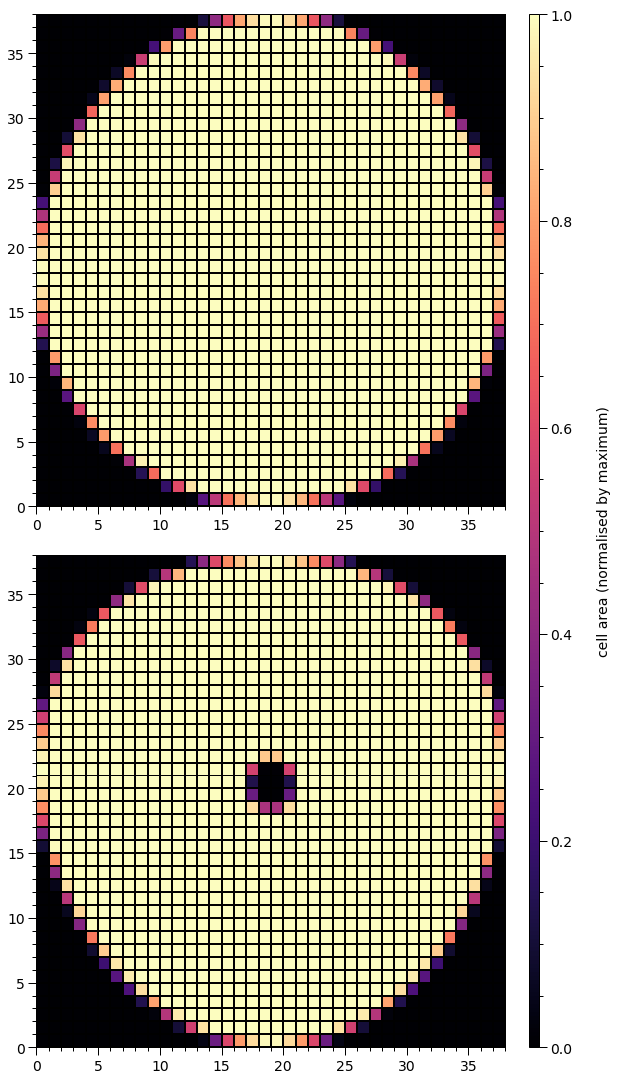

In [52]:
photosphere.integrate(energies=energies, threads=1)

plot_2D_pulse((photosphere.pulse[0][0], photosphere.pulse[1][0]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.025]),
              y=energies,
              ylabel=r'Energy (keV)')

plot_meshes()

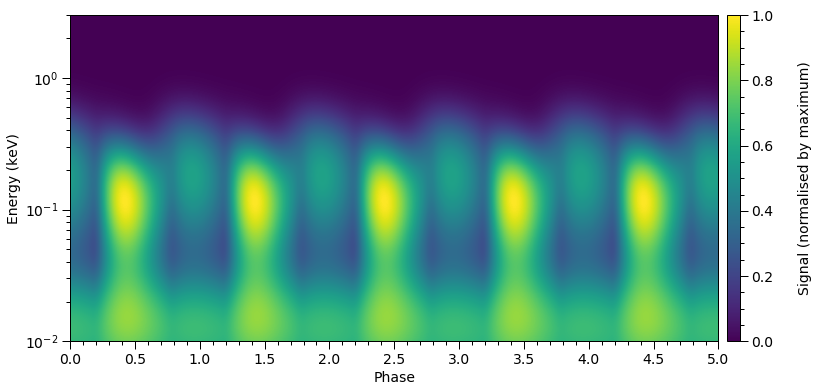

In [53]:
v.elsewhere_temp = 5.0 # shhuuuummm

star.update(v())

photosphere.integrate(energies=energies, threads=1)

plot_2D_pulse((photosphere.pulse[0][0], photosphere.pulse[1][0]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.025]),
              y=energies,
              ylabel=r'Energy (keV)')